## Modules and DataLoader

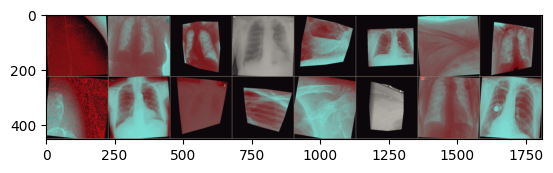

In [1]:
'''
We write this code with the help of PyTorch demo:
    https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html
  
'''

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

import random
import timm


RANDOM_SEED = 0

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


plt.ion()   # interactive mode

# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.CenterCrop((470,470)),
        transforms.RandomRotation(10,),
        transforms.RandomPerspective(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomGrayscale(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'val': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.507, 0.487, 0.441], std=[0.267, 0.256, 0.276])
    ]),
}

data_dir = '/kaggle/input/siim-dataset-with-sides/SIIM-FISABIO-RSNA-JPEG/SIIM-FISABIO-RSNA-JPEG'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=0)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#plt.rcParams['font.size'] = '12'
#plt.rcParams['figure.dpi'] = 600

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.savefig('Augmented_data_train.pdf')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out)#, title=[class_names[x] for x in classes])

## Models

In [2]:
class NullNet(nn.Module): 
    def __init__(self):
        super(NullNet, self).__init__()
    def forward(self, x):
        return x
    
#model_ft = models.vgg11_bn(pretrained=True)
#num_ftrs = model_ft.classifier[0].in_features

Num_class=3
model_ft = timm.create_model('vit_large_patch16_224', pretrained=True, num_classes=Num_class)
num_ftrs = model_ft.head.in_features

#model_ft = models.wide_resnet101_2(pretrained=True)
#num_ftrs = model_ft.fc.in_features

'''
Changing the fully connected layer 
'''
modelFC = nn.Linear(num_ftrs, Num_class)
model_ft.head = NullNet()

model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

## Training Function

In [3]:
def train_model_phase(model, model_conv, criterion, optimizer, scheduler, phase):
    
    if phase == 'train':
        model.train()  # Set model to training mode
    else:
        model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    for inputs, labels in dataloaders[phase]:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
            Features = model_conv(inputs)
            outputs = model(Features)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()
                

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        
    if phase == 'train':
        scheduler.step()

    epoch_loss = running_loss / dataset_sizes[phase]
    epoch_acc = running_corrects.double() / dataset_sizes[phase]

    
    
    return model, epoch_loss, epoch_acc

def train_model(model, model_conv, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    test_token = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val', 'test']: 
             
            
            '''
            Test when a better validation result is found
            '''
            if test_token ==0 and phase == 'test':
                continue
            test_token = 0
            
            model, epoch_loss, epoch_acc = train_model_phase(model, model_conv, criterion, optimizer, scheduler, phase)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))


            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                test_token = 1


        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

## Training lr = 0.0005

In [4]:
torch.manual_seed(14)

model_ft = model_ft.to(device)
modelFC = modelFC.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(modelFC.parameters(), lr=0.0005, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

modelFC = train_model(modelFC, model_ft, criterion, optimizer_ft, exp_lr_scheduler,num_epochs=3)

model_ft.head = modelFC

Epoch 1/3
----------
train Loss: 0.7345 Acc: 0.7280
val Loss: 0.8739 Acc: 0.7035
test Loss: 0.8312 Acc: 0.7224

Epoch 2/3
----------
train Loss: 0.7120 Acc: 0.7463
val Loss: 0.5869 Acc: 0.7350
test Loss: 0.5876 Acc: 0.7539

Epoch 3/3
----------
train Loss: 0.6385 Acc: 0.7650
val Loss: 0.6997 Acc: 0.7224

Training complete in 27m 51s
Best val Acc: 0.735016


## Confusion Matrix on training data

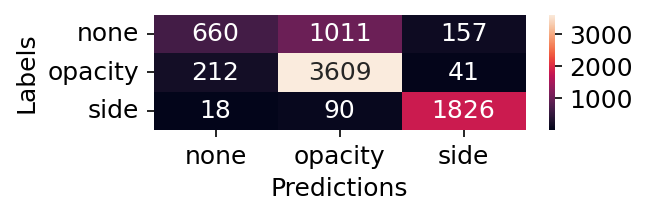

In [5]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for inputs, labels in dataloaders['train']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network
        output_all.extend(output.data.cpu().numpy())

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# constant for classes
classes = ('none', 'opacity', 'side')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])


plt.figure(figsize = (4,1),dpi=150)
plt.rcParams['font.size'] = '12'
sn.heatmap(df_cm, annot=True, fmt=".0f")
plt.ylabel("Labels")
plt.xlabel("Predictions")

with open('train.npy', 'wb') as f:
    np.save(f, output_all)
    np.save(f, y_true)

## Confusion Matrix on Validation Data

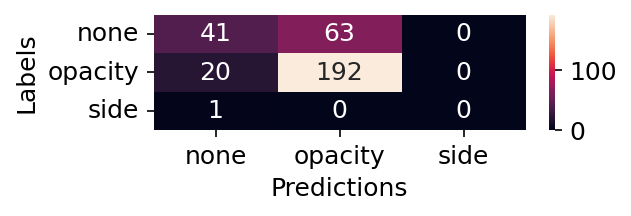

In [6]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for inputs, labels in dataloaders['val']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network
        output_all.extend(output.data.cpu().numpy())

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])



plt.figure(figsize = (4,1),dpi=150)
plt.rcParams['font.size'] = '12'
sn.heatmap(df_cm, annot=True, fmt=".0f")
plt.ylabel("Labels")
plt.xlabel("Predictions")

with open('val.npy', 'wb') as f:
    np.save(f, output_all)
    np.save(f, y_true)

## Confusion Matrix on Test Data

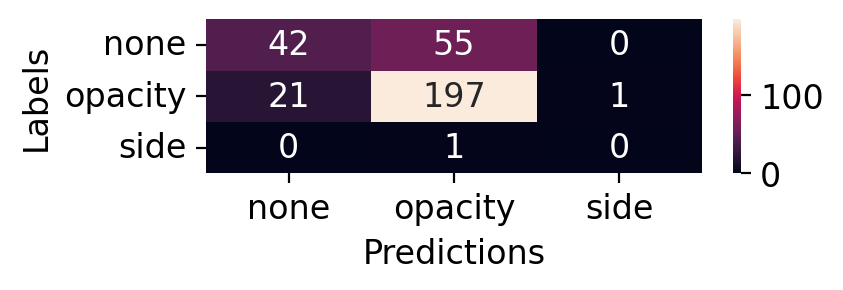

In [7]:
y_pred = []
y_true = []
output_all =[]

# iterate over test data
for inputs, labels in dataloaders['test']:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        output = model_ft(inputs) # Feed Network
        output_all.extend(output.data.cpu().numpy())

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth
        
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                     columns = [i for i in classes])



plt.figure(figsize = (4,1),dpi=200)
plt.rcParams['font.size'] = '12'
sn.heatmap(df_cm, annot=True, fmt=".0f")
plt.ylabel("Labels")
plt.xlabel("Predictions")

plt.savefig('CMAT_test.pdf')

with open('test.npy', 'wb') as f:
    np.save(f, output_all)
    np.save(f, y_true)
